In [1]:
import gym
import torch
import torch.nn as nn
env = gym.make('CartPole-v0')

/home/prayash/.local/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [17]:
class PolicyNetwork():
    def __init__(self,n_state,n_action,n_hidden=50,lr=0.001):
        self.model = nn.Sequential(
            nn.Linear(n_state,n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden,n_action),
            nn.Softmax()
        )

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def predict(self,s):
        return self.model(torch.Tensor(s))

    def update(self, returns,log_probs):
        policy_gradient = []
        for log_prob , Gt in zip(log_probs, returns ):
            policy_gradient.append(-log_prob*Gt )
        print(policy_gradient)
        loss = torch.stack(policy_gradient).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    def get_action(self, s):
        probs = self.predict(s)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action])
        return action , log_prob

            

In [18]:
state,_ = env.reset()
state

array([ 0.00647167, -0.02100678, -0.03126324,  0.02585465], dtype=float32)

In [19]:
def reinforce(env, estimator, n_episode, gamma=1.0):
    for episode in range(n_episode):
        log_probs = []
        rewards =  []
        state,_ = env.reset()

        while True:
            action, log_prob = estimator.get_action(state)
            next_state, reward , terminated, truncated , _= env.step(action)
            is_done = terminated or truncated
           # print(reward)
            total_reward_episode[episode] += reward
            log_probs.append(log_prob)
            rewards.append(reward)

            if is_done:
                returns = []
                Gt = 0 
                pw =0 
                for reward in rewards[::-1]:
                    Gt += gamma ** pw * reward
                    pw += 1 
                    returns.append(Gt)
                returns = returns[::-1]
                #print(returns.shape)
                returns = torch.tensor(returns )
                returns = (returns - returns.mean())/(returns.std() + 1e-9)
                estimator.update(returns, log_probs)
                print('Episode: {}, total reward: {}'.format(episode, total_reward_episode[episode]))
                break
                
            state = next_state


            

In [20]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n 
n_hidden = 128
lr = 0.003
policy_net = PolicyNetwork(n_state, n_action,n_hidden, lr)


In [21]:
gamma = 0.9

In [22]:
n_episode = 1000
total_reward_episode = [0] * n_episode
reinforce(env, policy_net, n_episode, gamma)

/home/prayash/.local/lib/python3.10/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[tensor(0.8565, grad_fn=<MulBackward0>), tensor(0.7339, grad_fn=<MulBackward0>), tensor(0.6177, grad_fn=<MulBackward0>), tensor(0.5500, grad_fn=<MulBackward0>), tensor(0.3489, grad_fn=<MulBackward0>), tensor(0.1922, grad_fn=<MulBackward0>), tensor(0.0215, grad_fn=<MulBackward0>), tensor(-0.1669, grad_fn=<MulBackward0>), tensor(-0.4376, grad_fn=<MulBackward0>), tensor(-0.5960, grad_fn=<MulBackward0>), tensor(-0.8455, grad_fn=<MulBackward0>), tensor(-1.3735, grad_fn=<MulBackward0>)]
Episode: 0, total reward: 12.0
[tensor(0.6745, grad_fn=<MulBackward0>), tensor(0.6343, grad_fn=<MulBackward0>), tensor(0.8083, grad_fn=<MulBackward0>), tensor(0.7625, grad_fn=<MulBackward0>), tensor(0.5656, grad_fn=<MulBackward0>), tensor(0.5166, grad_fn=<MulBackward0>), tensor(0.6435, grad_fn=<MulBackward0>), tensor(0.5807, grad_fn=<MulBackward0>), tensor(0.5089, grad_fn=<MulBackward0>), tensor(0.4291, grad_fn=<MulBackward0>), tensor(0.3136, grad_fn=<MulBackward0>), tensor(0.2802, grad_fn=<MulBackward0>), te

KeyboardInterrupt: 

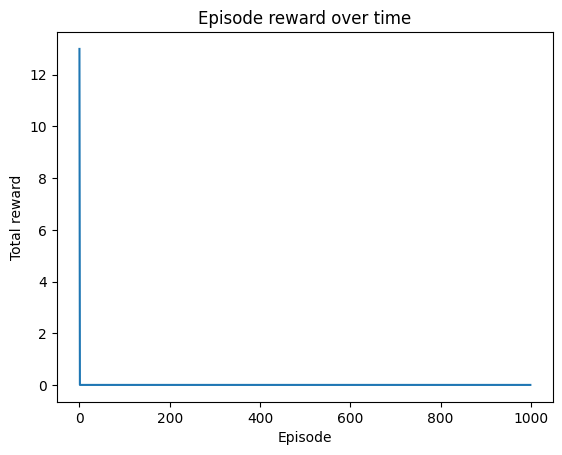

In [16]:



import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()